<a href="https://colab.research.google.com/github/josephobonyo/data_science_projects/blob/main/Google%20Analytics%20Multiple%20Regression/GStore%20Multiple%20Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GStore Customer Revenue Analytics
In this competition, the aim is to analyze a Google Merchandise Store (also known as GStore, where Google swag is sold) customer dataset to predict revenue per customer. The results of predictions and analysis might lead to more actionable operational changes and a better use of marketing budgets for those companies who choose to use data analysis on top of GA data. This is the starter baseline kernel, I will be updating it frequently.

In [17]:
!kaggle competitions download -c ga-customer-revenue-prediction -f train.csv

 83% 51.0M/61.1M [00:02<00:00, 34.0MB/s]
100% 61.1M/61.1M [00:03<00:00, 19.5MB/s]


In [18]:
! unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
import numpy as np 
import pandas as pd 
import json  # For columns that need to be extracted from json format
from pandas import json_normalize  # For columns that need to be extracted from json format
from datetime import datetime  # For handling datetime format
import random

## Step 1: Import Data

In [20]:
DATA_FILE = 'train.csv'

json_cols = ['device', 'geoNetwork', 'totals', 'trafficSource']
def load_data(path):
    
    df = pd.read_csv(path, converters={column: json.loads for column in json_cols}, 
                     dtype={'fullVisitorId': 'str'})
    
    for column in json_cols:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}_{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    
    print('Dataframe shape: ', df.shape)
    
    return df

def process_date(df):
    df["date"] = pd.to_datetime(df["date"], format="%Y%m%d") # seting the column as pandas datetime
    df["_weekday"] = df['date'].dt.weekday #extracting week day
    df["_day"] = df['date'].dt.day # extracting day
    df["_month"] = df['date'].dt.month # extracting day
    df["_year"] = df['date'].dt.year # extracting day
    df['_visitHour'] = (df['visitStartTime'].apply(lambda x: str(datetime.fromtimestamp(x).hour))).astype(int)

    return df

def read_data(path):
    df = load_data(path)
    df = process_date(df)
    
    return df

In [21]:
train = read_data(DATA_FILE)

Dataframe shape:  (903653, 55)


## Step 2: Clean Data

#### Check for missing values

In [22]:
# The following are data analysis functions that will inform decision making on how the data is cleaned

def display_shape(df):
    '''
    This function displays the shape of the dataframe and the counts of the different variable types
    '''
    print('Number of rows : {} / number of columns : {}'.format(df.shape[0], df.shape[1]))

    print('\ntypes of variables :\n')
    print(df.dtypes.value_counts())
    

def display_homogeneous_columns(df):
    ''' 
    This function displays all columns where we have only one unique value (constants)
    This is useful because these columns don't give us any information 
    '''
    discovering_consts = [col for col in df.columns if df[col].nunique() == 1]

    # printing the total of columns dropped and the name of columns
    print("\nNumber of columns with just one value: ", len(discovering_consts), "columns")
    print("Name of constant columns: \n", discovering_consts)
    
    
def display_id_columns(df):
    ''' 
    This function displays all columns where the number of unique values is the same as the entire dataset like an id.
    This is useful because these columns don't give us any information .
    '''
    discovering_shape = [col for col in df.columns if df[col].nunique() == df.shape[0]]

    # printing the total of columns dropped and the name of columns
    print("\nNumber of columns with same size as df rows: ", len(discovering_shape), "columns")
    print("Name of id columns: \n", discovering_shape)
    

def display_high_missing_vals(df):
    '''
    This function displays the percentage of missing values in columns that have them.
    It also displays the columns with more that 50% missing values. These will be dropped as they don't add 
    much information to the analysis.
    '''
    # Percentage of NAN Values 
    nan = [(i, df[i].isna().mean()*100) for i in df]
    nan = pd.DataFrame(nan, columns=["column_name", "percentage"])

    # Display the columns with missing values
    nan = nan[nan.percentage > 0]
    print("\nPercentage of missing values: \n", nan.sort_values("percentage", ascending=False))
    
    # Display the columns with more than 50% missing values
    high_nan = nan.loc[nan['percentage'] > 50, 'column_name']
    print("\nColumns with more than 50% missing values: \n", list(high_nan.values))

In [23]:
def display_descriptive_stats(df):
    '''
    This function calls all the functions above that will be used to analyse the data.
    '''
    df = df.copy()
    display_shape(df)
    display_homogeneous_columns(df)
    display_id_columns(df)
    display_high_missing_vals(df)

In [24]:
display_descriptive_stats(train)

Number of rows : 903653 / number of columns : 60

types of variables :

object            50
int64              8
bool               1
datetime64[ns]     1
dtype: int64

Number of columns with just one value:  24 columns
Name of constant columns: 
 ['socialEngagementType', 'device_browserVersion', 'device_browserSize', 'device_operatingSystemVersion', 'device_mobileDeviceBranding', 'device_mobileDeviceModel', 'device_mobileInputSelector', 'device_mobileDeviceInfo', 'device_mobileDeviceMarketingName', 'device_flashVersion', 'device_language', 'device_screenColors', 'device_screenResolution', 'geoNetwork_cityId', 'geoNetwork_latitude', 'geoNetwork_longitude', 'geoNetwork_networkLocation', 'totals_visits', 'totals_bounces', 'totals_newVisits', 'trafficSource_adwordsClickInfo.criteriaParameters', 'trafficSource_isTrueDirect', 'trafficSource_adwordsClickInfo.isVideoAd', 'trafficSource_campaignCode']

Number of columns with same size as df rows:  0 columns
Name of id columns: 
 []

Percentag

Most of the columns we're dealing with are object columns.  
The columns with one unique value and with more than 50% missing values will be dropped.

In [25]:
# Create list to drop all the columns with one unique value
unique_columns_drop = set(['socialEngagementType', 'device_browserVersion', 'device_browserSize', 'device_operatingSystemVersion', 'device_mobileDeviceBranding',
                           'device_mobileDeviceModel', 'device_mobileInputSelector', 'device_mobileDeviceInfo', 'device_mobileDeviceMarketingName', 
                           'device_flashVersion', 'device_language', 'device_screenColors', 'device_screenResolution', 'geoNetwork_cityId', 
                           'geoNetwork_latitude', 'geoNetwork_longitude', 'geoNetwork_networkLocation', 'totals_visits', 'totals_bounces', 'totals_newVisits', 
                           'trafficSource_adwordsClickInfo.criteriaParameters', 'trafficSource_isTrueDirect', 'trafficSource_adwordsClickInfo.isVideoAd', 
                           'trafficSource_campaignCode', 'date'])

# Drop columns
train = train.drop(unique_columns_drop, axis=1)
print("Total unique features dropped: ", len(unique_columns_drop))

# Create list to drop columns with a high percentage of missing values and any ID columns that do not add any information
high_missing_vals_drop = set(['totals_bounces', 'trafficSource_keyword', 'trafficSource_isTrueDirect', 
                              'trafficSource_referralPath', 'trafficSource_adwordsClickInfo.page', 'trafficSource_adwordsClickInfo.slot', 
                              'trafficSource_adwordsClickInfo.gclId', 'trafficSource_adwordsClickInfo.adNetworkType', 
                              'trafficSource_adwordsClickInfo.isVideoAd', 'trafficSource_adContent', 'trafficSource_campaignCode', 'sessionId',
                              'fullVisitorId', 'visitId', 'visitStartTime'])
high_missing_vals_drop = [x for x in high_missing_vals_drop if x not in unique_columns_drop]

# Drop columns
train = train.drop(high_missing_vals_drop, axis=1)
print("Total high missing value features dropped: ", len(high_missing_vals_drop))

# Display shape after columns have been dropped
print("\nShape after dropping columns: ")
display_shape(train)

Total unique features dropped:  25
Total high missing value features dropped:  11

Shape after dropping columns: 
Number of rows : 903653 / number of columns : 24

types of variables :

object    17
int64      6
bool       1
dtype: int64


In [26]:
# We'll display the descriptive statistics again to get a good view of all the remaining data
display_descriptive_stats(train)

Number of rows : 903653 / number of columns : 24

types of variables :

object    17
int64      6
bool       1
dtype: int64

Number of columns with just one value:  0 columns
Name of constant columns: 
 []

Number of columns with same size as df rows:  0 columns
Name of id columns: 
 []

Percentage of missing values: 
                   column_name  percentage
15  totals_transactionRevenue   98.725728
14           totals_pageviews    0.011066

Columns with more than 50% missing values: 
 ['totals_transactionRevenue']


'totals_transactionRevenue' is exluded from being dropped because it will be used for our target. It has a high percentage of missing values because of the general low turnover in E-Commerce sites.  
The next step is to take a look at the unique values of each column, grouping them by data type

In [27]:
def display_unique_values(df, data_type, limit=10): 
    '''
    This function displays all the unique values in a certain column based on the data type
    '''
    n = df.select_dtypes(include=data_type) #selecting the desired data type
    for column in n.columns: #initializing the loop
        print("##############################################")
        print("Name of column ", column, ': \n', "Uniques: ", df[column].unique()[:limit], "\n",
              " | ## Total nulls: ", (round(df[column].isnull().sum() / len(df[column]) * 100,2)),
              " | ## Total unique values: ", df.nunique()[column]) #print the data and % of nulls)
        print("#############################################")

In [28]:
print("\n Object --------")
display_unique_values(train, data_type= object)
print("\n int --------")
display_unique_values(train, data_type= int)
print("\n float --------")
display_unique_values(train, data_type= float)
print("\n bool --------")
display_unique_values(train, data_type= bool)


 Object --------
##############################################
Name of column  channelGrouping : 
 Uniques:  ['Organic Search' 'Referral' 'Paid Search' 'Affiliates' 'Direct' 'Display'
 'Social' '(Other)'] 
  | ## Total nulls:  0.0  | ## Total unique values:  8
#############################################
##############################################
Name of column  device_browser : 
 Uniques:  ['Chrome' 'Firefox' 'UC Browser' 'Internet Explorer' 'Safari' 'Edge'
 'Opera Mini' 'Opera' 'BlackBerry' 'Safari (in-app)'] 
  | ## Total nulls:  0.0  | ## Total unique values:  54
#############################################
##############################################
Name of column  device_operatingSystem : 
 Uniques:  ['Windows' 'Macintosh' 'Linux' 'Android' 'iOS' 'Chrome OS' 'BlackBerry'
 '(not set)' 'Samsung' 'Windows Phone'] 
  | ## Total nulls:  0.0  | ## Total unique values:  20
#############################################
##############################################
Name of col

Some numerical values should be integer like page views and hits, the nan transaction value will be set to 0 (nan mean no conversion : no transaction).

Some object features get values like 'not set' because they are not missing

Let's clean and replace some values to get a better view on our data :

In [29]:
def fill_replace_values(df):
    # fillna numeric feature
    df['totals_pageviews'].fillna(df['totals_pageviews'].value_counts().index[0], inplace=True) #filling NA's with the most Frequent value
    df["totals_pageviews"] = df["totals_pageviews"].astype(int) # setting numerical to int
    df["totals_hits"] = df["totals_hits"].astype(int) # setting numerical to int
    df["totals_transactionRevenue"] = df["totals_transactionRevenue"].fillna(0.0).astype(float)

    #object feature
    # --> Replace unknown values
    df.loc[df['channelGrouping'] == '(Other)', 'channelGrouping'] = np.nan
    df.loc[df['device_operatingSystem'] == '(not set)', 'device_operatingSystem'] = np.nan
    df.loc[df['geoNetwork_continent'] == '(not set)', 'geoNetwork_continent'] = np.nan
  
    return df #return the transformed dataframe

In [30]:
train = fill_replace_values(train)
display_descriptive_stats(train)

Number of rows : 903653 / number of columns : 24

types of variables :

object     14
int64       8
bool        1
float64     1
dtype: int64

Number of columns with just one value:  0 columns
Name of constant columns: 
 []

Number of columns with same size as df rows:  0 columns
Name of id columns: 
 []

Percentage of missing values: 
               column_name  percentage
3  device_operatingSystem    0.519558
6    geoNetwork_continent    0.162452
0         channelGrouping    0.013279

Columns with more than 50% missing values: 
 []


In [31]:
#to clean the data we drop nan rows
train.dropna(axis = 0, inplace=True)
print("Shape after dropping: ", train.shape)

Shape after dropping:  (897549, 24)


## Step 3: Explore Data

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import mean

In [33]:
# We will split data into predictors and the target
y = train['totals_transactionRevenue']
X = train.drop('totals_transactionRevenue', axis=1)

# Since most values of y are zero, we will get the non-zero values
y_non_zero = y[y > 0]

# We will also calculate the natural log of the non_zero values for the purpose of making the visualizations
y_log = np.log1p(y_non_zero)

In [34]:
# Here we create a new dataframe that excludes non-zero values of transaction revenue and calculates the natural log of these values
# This is to improve to give a better representation of the instances in which there is revenue being made
plot_df = train
plot_df = plot_df[plot_df['totals_transactionRevenue'] > 0]
plot_df.loc[:,'totals_transactionRevenue'] = np.log1p(plot_df['totals_transactionRevenue'].values)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


#### 3.1: Transaction Revenue

Text(0.5, 1.0, 'Distribution of Non-Zero Transaction Revenue')

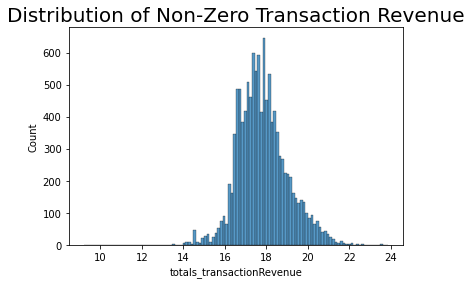

In [35]:
# Plotting histogram of Transaction Revenue
fig, ax = plt.subplots()
sns.histplot(x=plot_df['totals_transactionRevenue'], ax=ax)
ax.set_title('Distribution of Non-Zero Transaction Revenue', fontsize=20)

Despite 98% of the transactions having a value of 0, the non-zero values are negatively skewed.

#### 3.2: Time Attributes

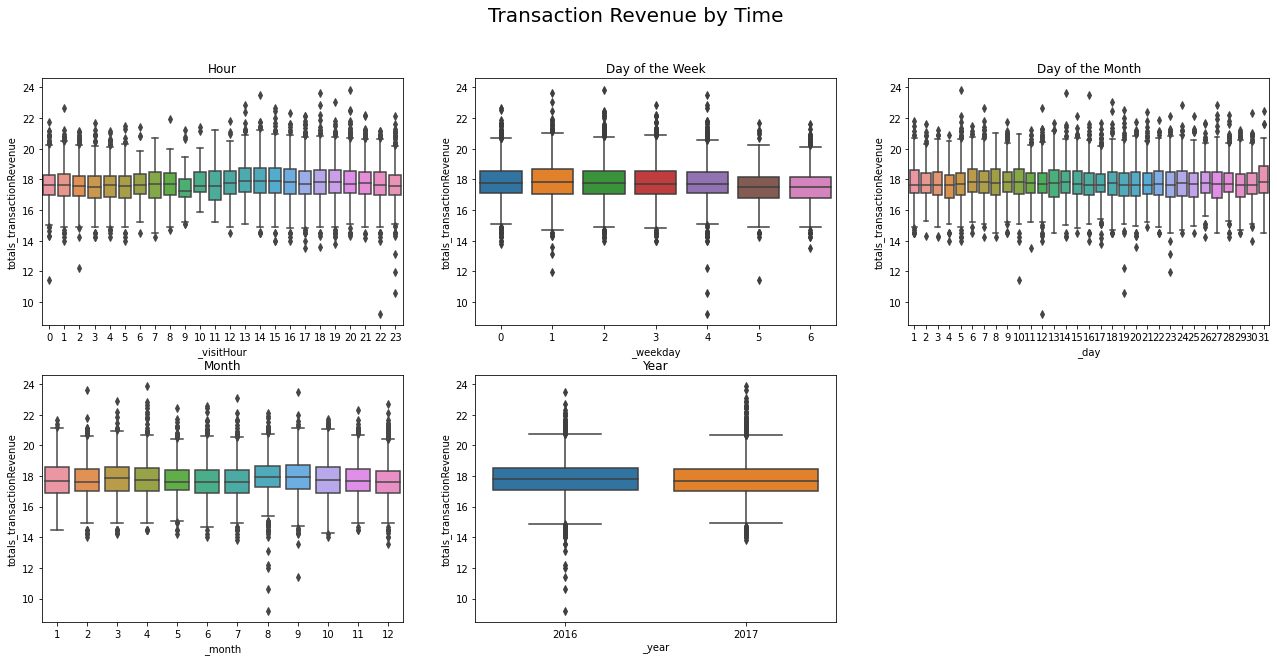

In [36]:
# Plotting box plots of revenue for different time periods. Non-zero values are used for these plots.
fig, ((ax, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(2, 3, figsize=(22, 10))
plt.suptitle('Transaction Revenue by Time', fontsize=20)
sns.boxplot(x=plot_df['_visitHour'], y=plot_df['totals_transactionRevenue'], ax=ax).set_title('Hour')
sns.boxplot(x=plot_df['_weekday'], y=plot_df['totals_transactionRevenue'], ax=ax1).set_title('Day of the Week')
sns.boxplot(x=plot_df['_day'], y=plot_df['totals_transactionRevenue'], ax=ax2).set_title('Day of the Month')
sns.boxplot(x=plot_df['_month'], y=plot_df['totals_transactionRevenue'], ax=ax3).set_title('Month')
sns.boxplot(x=plot_df['_year'], y=plot_df['totals_transactionRevenue'], ax=ax4).set_title('Year')
fig.delaxes(ax=ax5)  # This line will delete the last empty plot. Use if number of axes doesn't match the subplots

The spread in Transaction Revenues is consistent in all time periods with slight differences in skew.

#### 3.3: Device Attributes

Text(0.5, 1.0, 'Device')

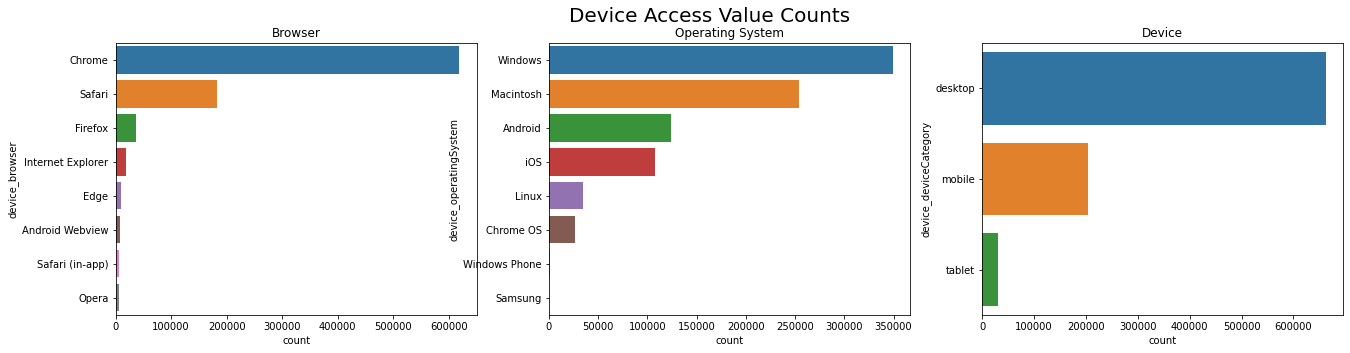

In [37]:
fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(22, 5))
plt.suptitle('Device Access Value Counts', fontsize=20)
sns.countplot(y=train['device_browser'], order=train['device_browser'].value_counts().iloc[:8].index, ax=ax).set_title('Browser')
sns.countplot(y=train['device_operatingSystem'], order=train['device_operatingSystem'].value_counts().iloc[:8].index, ax=ax1).set_title('Operating System')
sns.countplot(y=train['device_deviceCategory'], order=train['device_deviceCategory'].value_counts().index, ax=ax2).set_title('Device')

Chrome, as the most popular internet browser, also account for the highest number of visits for the GStore.  
Desktops account for a much higher number of visits. This is also seen when comparing operating systems.

Text(0.5, 1.0, 'Mean Transaction Revenue by Device')

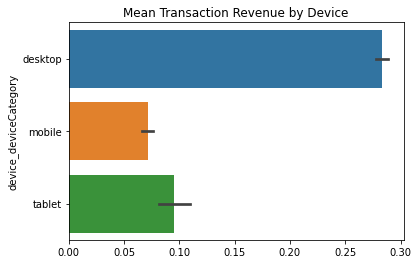

In [38]:
# Plotting mean transaction revenue
fig, ax = plt.subplots()
sns.barplot(data=train, y='device_deviceCategory', x=np.log1p(train['totals_transactionRevenue'].values), ax=ax).set_title('Mean Transaction Revenue by Device')

Tablets have a higher mean transaction revenue despite having fewer visits.

#### 3.4: Geographic Attributes

Text(0.5, 1.0, 'City')

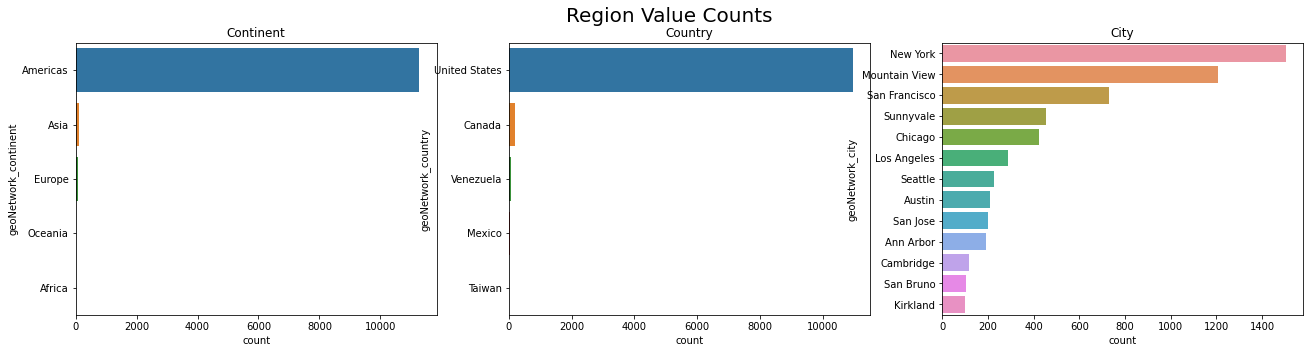

In [39]:
fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(22, 5))
plt.suptitle('Region Value Counts', fontsize=20)
sns.countplot(y=plot_df['geoNetwork_continent'], order=plot_df['geoNetwork_continent'].value_counts().index, ax=ax).set_title('Continent')
sns.countplot(y=plot_df['geoNetwork_country'], order=plot_df['geoNetwork_country'].value_counts().iloc[:5].index, ax=ax1).set_title('Country')
sns.countplot(y=plot_df['geoNetwork_city'], order=plot_df['geoNetwork_city'].value_counts().iloc[1:14].index, ax=ax2).set_title('City')

The Americas make up most of the visits to the store. Considering the ease of shipping within the United States, this makes sense, as can be seen from the Country graph.  
The cities that have the most visits are all large, densely populated cities.

Text(0.5, 1.0, 'Mean Transaction Revenue by Continent')

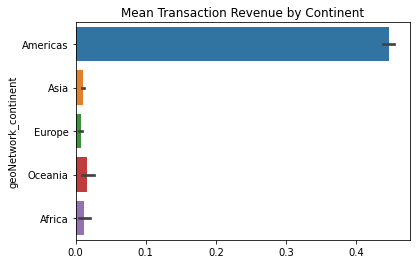

In [40]:
# We will only use the continent in this section as the other have too much information and sorting takes too much computing power
fig, ax = plt.subplots()
sns.barplot(data=train, y='geoNetwork_continent', x=np.log1p(train['totals_transactionRevenue'].values),order=train['geoNetwork_continent'].value_counts().index,
            ax=ax).set_title('Mean Transaction Revenue by Continent')

The Mean Transaction Revenue by Continent follows the same patter as the number of visits.

## 4: Train Models

### Models Used
- #### Ordinary Least Squares (sklearn LinearRegression)
 - LinearRegression fits a linear model with coefficients w = (w1, …, wp) to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation.
- #### Linear Support Vector Regression
 - SVR tries to find the best fit line. In SVR, the best fit line is the hyperplane that has the maximum number of points. SVR is slow and doesn't scale well to datasets with more than 10,000 samples so Linear SVR is used.
- #### Decision Tree Regression
 - Decision tree builds regression or classification models in the form of a tree structure. It breaks down a dataset into smaller and smaller subsets while at the same time an associated decision tree is incrementally developed. The final result is a tree with decision nodes and leaf nodes.
- #### Gradient Boosting Regression
 - Gradient Boosting Regression starts with a leaf that is the average of the target and creates trees to make predictions. Each tree is based on the error of the previous tree, and scales the tree to avoid overfitting.
- #### K-Neighbors Regression
 - K-Neighbors uses feature similarity to make predictions.
- #### Ridge Regression
 - Ridge Regression is a variant of Ordinary Least Squares that shrinks the parameters and reduces variances, helping to deal with data that has multicollinearity. 

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import RFECV

In [42]:
# train/test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [43]:
def evaluation(model, X_train, X_test, y_train, y_test):
    from sklearn.metrics import mean_squared_error
    from sklearn.model_selection import learning_curve
    
    print('\n ----- RMSE Evaluation : \n')

    y_test = np.log1p(y_test)
    y_train = np.log1p(y_train)

    model.fit(X_train, y_train)

    y_predict_test = model.predict(X_test)
    y_predict_train = model.predict(X_train)

    train_score = mean_squared_error(y_train, y_predict_train, squared=False)
    print('train score =', train_score)

    test_score = mean_squared_error(y_test, y_predict_test, squared=False)
    print('test score =', test_score)

    '''
    learning curve visualisation
    '''
    
    N, train_score, val_score = learning_curve(model, X_train, y_train, train_sizes = np.linspace(0.1, 1.0, 10), cv=4, scoring='neg_root_mean_squared_error')

#     print(N)
#     plt.plot(N,train_score.mean(axis=1), label='train')
#     plt.plot(N,val_score.mean(axis=1), label='validation')
#     plt.xlabel('train_sizes')
#     plt.legend()
#     plt.show()

    print('-----End Evaluation-----\n')

In [44]:
# Fit the data to the ordinal encoder
X_copy = X_train
X_copy_test = X_test
encoder = OrdinalEncoder()
encoder.fit(X)

X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)

# Prepare to fit all the models
preprocessor = make_pipeline(StandardScaler())
DTR = make_pipeline(preprocessor, DecisionTreeRegressor(random_state = 0))
SVR = make_pipeline(preprocessor, LinearSVR(random_state = 0))
OLS = make_pipeline(preprocessor, LinearRegression())
BOOST = make_pipeline(preprocessor, GradientBoostingRegressor(random_state = 0))
# NKR = make_pipeline(preprocessor, KNeighborsRegressor(n_jobs = -1))
# Ridge_algo = make_pipeline(preprocessor, Ridge(random_state = 0, alpha=.5))  

# dict_of_models = {'SVR':SVR,
#                   'OLS': OLS,
#                   'DTR':DTR,
#                   'BOOST':BOOST}
dict_of_models = {'BOOST':BOOST}

# Fit all the models 1 by 1
for name, model in dict_of_models.items():
    print('Evaluation of -----',name)
    evaluation(model, X_train, X_test, y_train, y_test)

Evaluation of ----- BOOST

 ----- RMSE Evaluation : 

train score = 1.6546486636816253
test score = 1.653435712340953


KeyboardInterrupt: ignored

- K-Neigbours Regresion was left out because it requires to much time and too much of the computer's resources to be efficient in this project.  
- Ridge Regression is left out because there is not advantage to using Ridge over OLS in this case due to the number of observations. Results were exactly the same.
- Decision Tree Regressor overfits the data all the way through. These results are not useful to us.
- Testing scores for OLS and SVR are both constant throughout, though OLS has better scores.
- The testing score for Gradient Boosting Regressor gets better as more observations are added.

## 5: Model Evaluation
Since we got by far the best results out of the Gradient Boosting Regressor, we will calculate feature importances of each of the attributes and test the model again after dropping some attributes.

### Feature Importances

In [ ]:
# Using the Gradient Boosting Model to calculate feature importances
IFe = BOOST.named_steps["gradientboostingregressor"].feature_importances_
print(pd.DataFrame(IFe, index=X_copy.columns))
pd.DataFrame(IFe, index=X_copy.columns).plot.bar()
plt.show()

In [ ]:
# Select and display features with less than 0.01 importance
selection = X_copy.columns[IFe<0.01]
print(selection)

Page views is by far the most important. We will remove the columns with a feauture importance of less than 0.01 as they don't contribute anything significant to the results. According to the feature importances, most of the columns are not very important. We expect that the RMSE will increase marginally (not enough to really affect the accuracy), since some information that the Gradient Boosting would have otherwise used is lost, however, the algorithm should be a lot faster to run with fewer attributes.

In [ ]:
# Fit the data to the ordinal encoder
X_copy = X_train
X_copy_test = X_test
encoder = OrdinalEncoder()
encoder.fit(X)

X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)

In [ ]:
# Create a list of columns to drop
to_drop = ['channelGrouping', 'device_browser', 'device_operatingSystem', 'device_deviceCategory', 'geoNetwork_continent', 'geoNetwork_subContinent','geoNetwork_region', 'geoNetwork_metro', 'geoNetwork_city','geoNetwork_networkDomain', 'trafficSource_campaign','trafficSource_medium', 
          '_weekday', '_day', '_year', '_visitHour']

X_train = pd.DataFrame(data = X_train, index = X_copy.index, columns = X_copy.columns)
X_test = pd.DataFrame(data = X_test, index = X_copy_test.index, columns = X_copy_test.columns)

X_train.isna().sum()
# Drop columns with low feature importance
X_train.drop(to_drop, axis=1, inplace=True)
X_test.drop(to_drop, axis=1, inplace=True)

# Create a new model dictionary
new_model_dict = {'BOOST':BOOST}

for name, model in new_model_dict.items():
    print('Evaluation of -----',name)
    evaluation(model, X_train, X_test, y_train, y_test)

## Conclusions
- As expected there was a marginal increase in RMSE after removing features 
- Final testing RMSE of 1.66 which is less than our target of 2.0
- We have learned through the process cleaning an feature selection that only 8 of the total of 55 columns were actually useful in predicting the Transaction Revenue
- The most important features are: Total Page Views, Country, Traffic Source (e.g. Google, Baidu, Bing), and Total Hits (total interactions with website)

### How does this help businesses?
- Businesses can focus marketing on certain regions
- It is important for them to get as much interaction with their website as possible
- This interaction can come in many forms e.g. social media views, likes, ads, clicks 